# KNN Project 


## The Sonar Data 

### Detecting a Rock or a Mine

Sonar (sound navigation ranging) is a technique that uses sound propagation (usually underwater, as in submarine navigation) to navigate, communicate with or detect objects on or under the surface of the water, such as other vessels.

<img src="images/sonar.jpg"  style="max-height: 500px; max-width: 500px;">

The data set contains the response metrics for 60 separate sonar frequencies sent out against a known mine field (and known rocks). These frequencies are then labeled with the known object they were beaming the sound at (either a rock or a mine). 

<img src="images/mine.jpg"  style="max-height: 500px; max-width: 500px;">

Our main goal is to create a machine learning model capable of detecting the difference between a rock or a mine based on the response of the 60 separate sonar frequencies.


Data Source: https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)


## 1. Setup and Imports
**Importing Libraries necessary libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import joblib

## 2. Loading the Data

In [2]:
df = pd.read_csv('DATA/sonar.all-data.csv')

In [3]:
df.head()

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_52,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


## 3. Exploratory Data Analysis

### 1. Class-Balance Bar Chart

**What it shows:**  
A count of Rock (R) vs. Mine (M) observations in the Sonar dataset.  

**Why it matters:**  
K-Nearest Neighbors relies on majority voting among neighbors. If one class heavily outweighs the other, predictions will be biased toward the majority.  
```

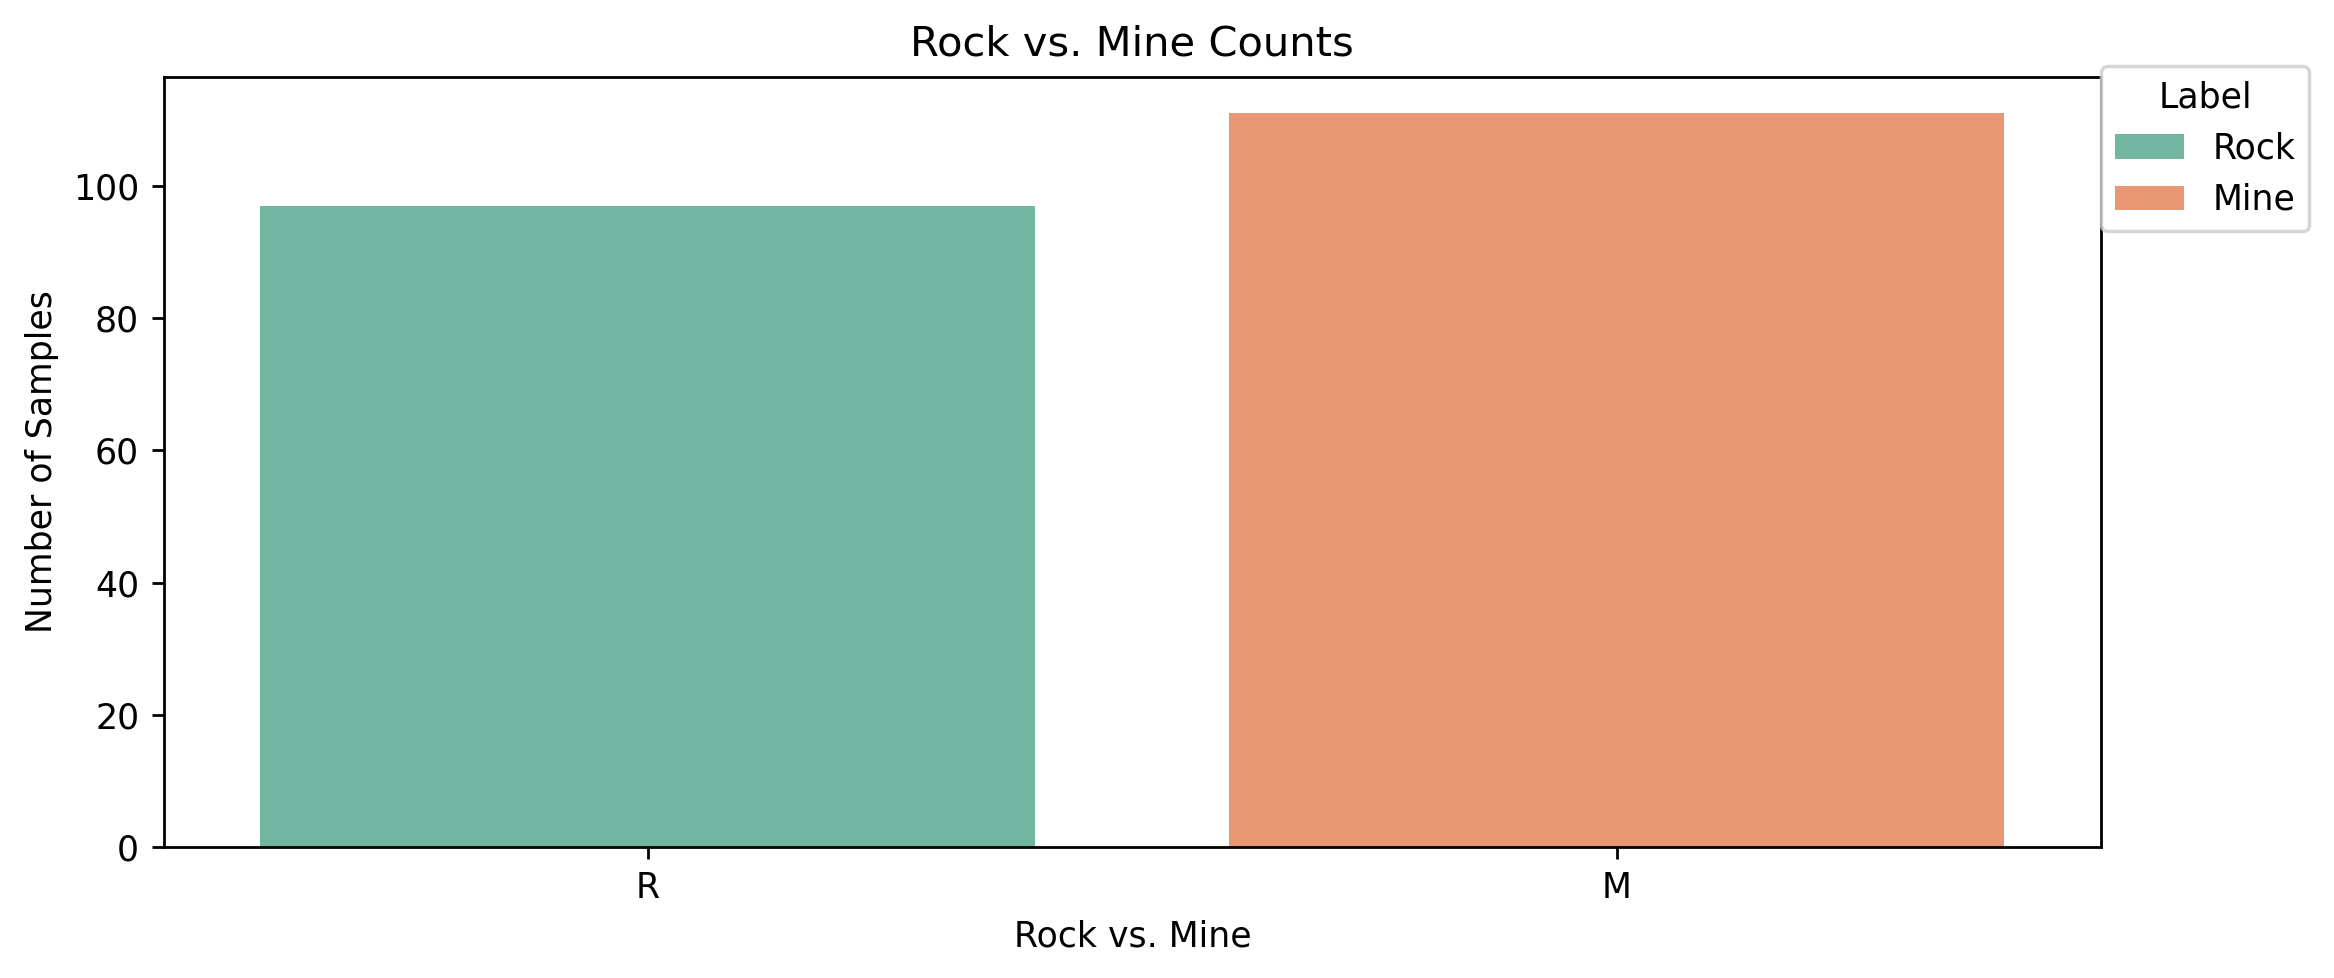

In [4]:
plt.figure(figsize=(10,4),dpi=250)
sns.countplot(x='Label', data=df,hue='Label', palette='Set2')
plt.title('Rock vs. Mine Counts')
plt.ylabel('Number of Samples')
plt.xlabel('Rock vs. Mine')
plt.legend(title='Label', labels=['Rock', 'Mine'],loc=[1,0.8])
plt.savefig('visualizations/rock_mine_counts.png')

### 2. Mean Sonar Signature by Class

**What it shows:**  
The average sonar echo (mean amplitude) at each of the 60 frequency bands, plotted separately for Rocks and Mines.  

**Why it matters:**  
Differences in these two curves highlight which frequency ranges carry the strongest discriminatory signal — essential for understanding which features KNN will leverage.  


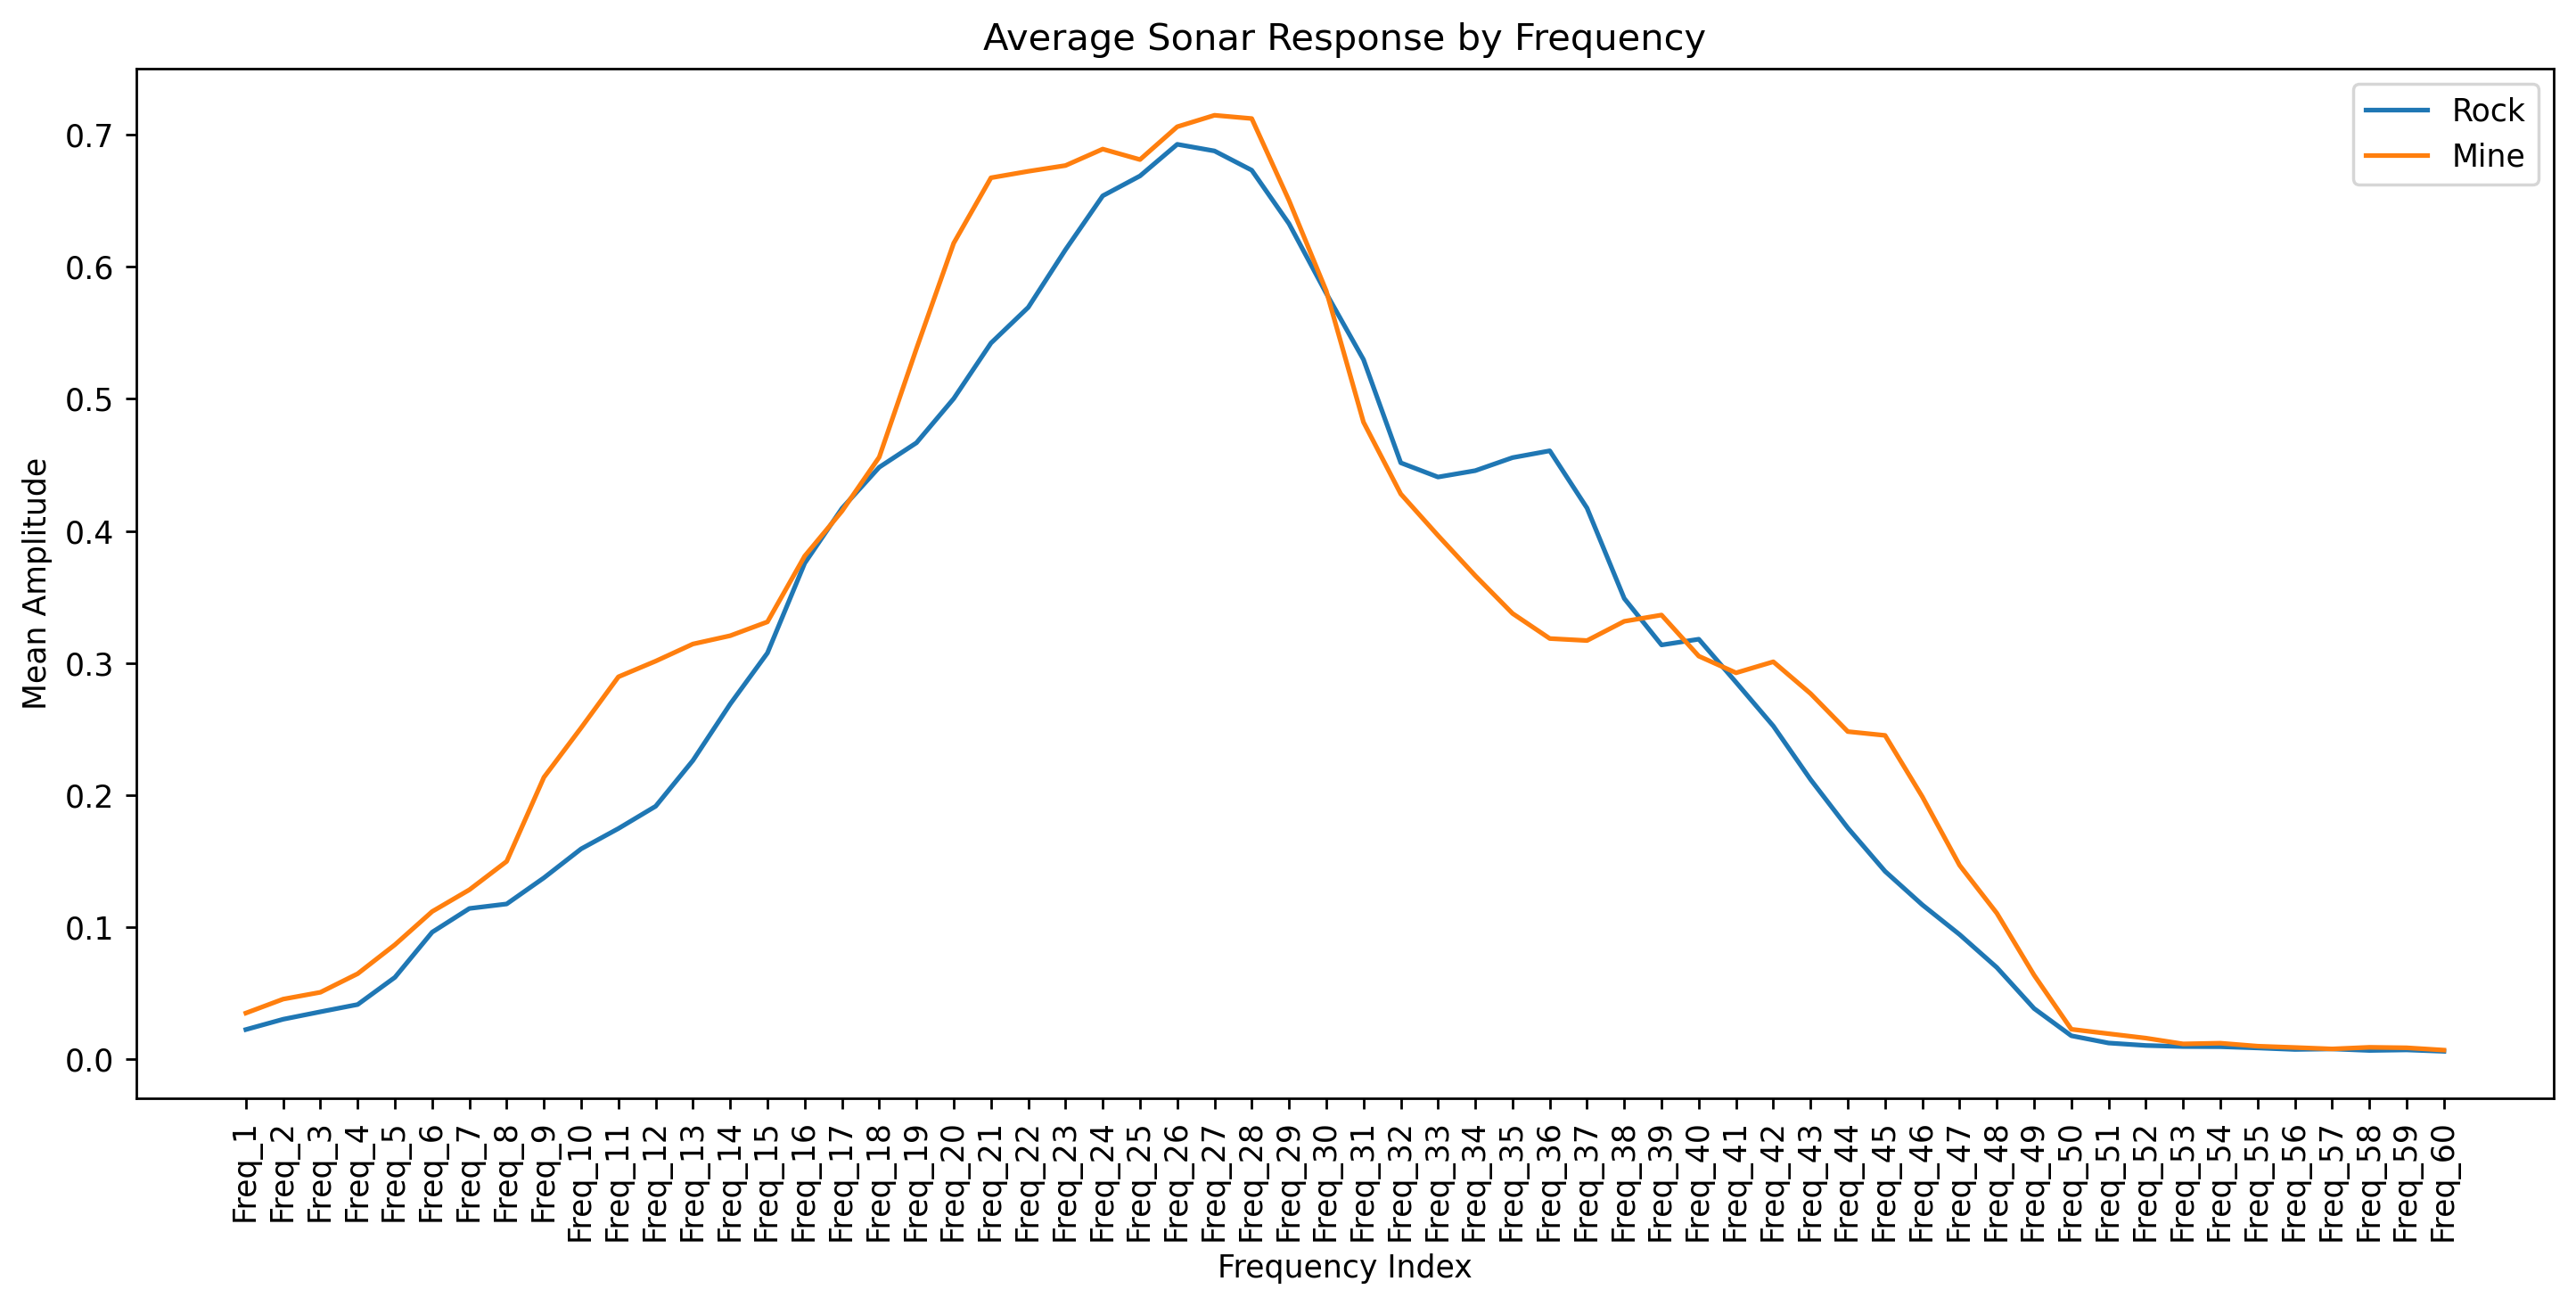

In [5]:

mean_R = df[df['Label']=='R'].iloc[:,:60].mean()
mean_M = df[df['Label']=='M'].iloc[:,:60].mean()
plt.figure(figsize=(14,6),dpi=250)
plt.plot(mean_R, label='Rock', color='C0')
plt.plot(mean_M, label='Mine', color='C1',)
plt.title('Average Sonar Response by Frequency')
plt.xlabel('Frequency Index')
plt.ylabel('Mean Amplitude')
plt.xticks(rotation=90)
plt.legend()
plt.savefig('visualizations/average_sonar_response.png')

### 3. Distributions of Sample‐Level Summary Statistics

**What it shows:**  
Overlaid KDE plots of four per-sample summary metrics — mean, standard deviation, maximum, and minimum amplitude across all frequencies — for each class.  

**Why it matters:**  
If simple statistics already separate the classes, KNN may not need all 60 features; dimensionality reduction could be effective.  

**Interpretation prompts:**  
- Do Mines show consistently higher/lower variance?  
- Are there clear gaps in min or max values?  
```

-----------------------------------------------------------------------------------------------------------------

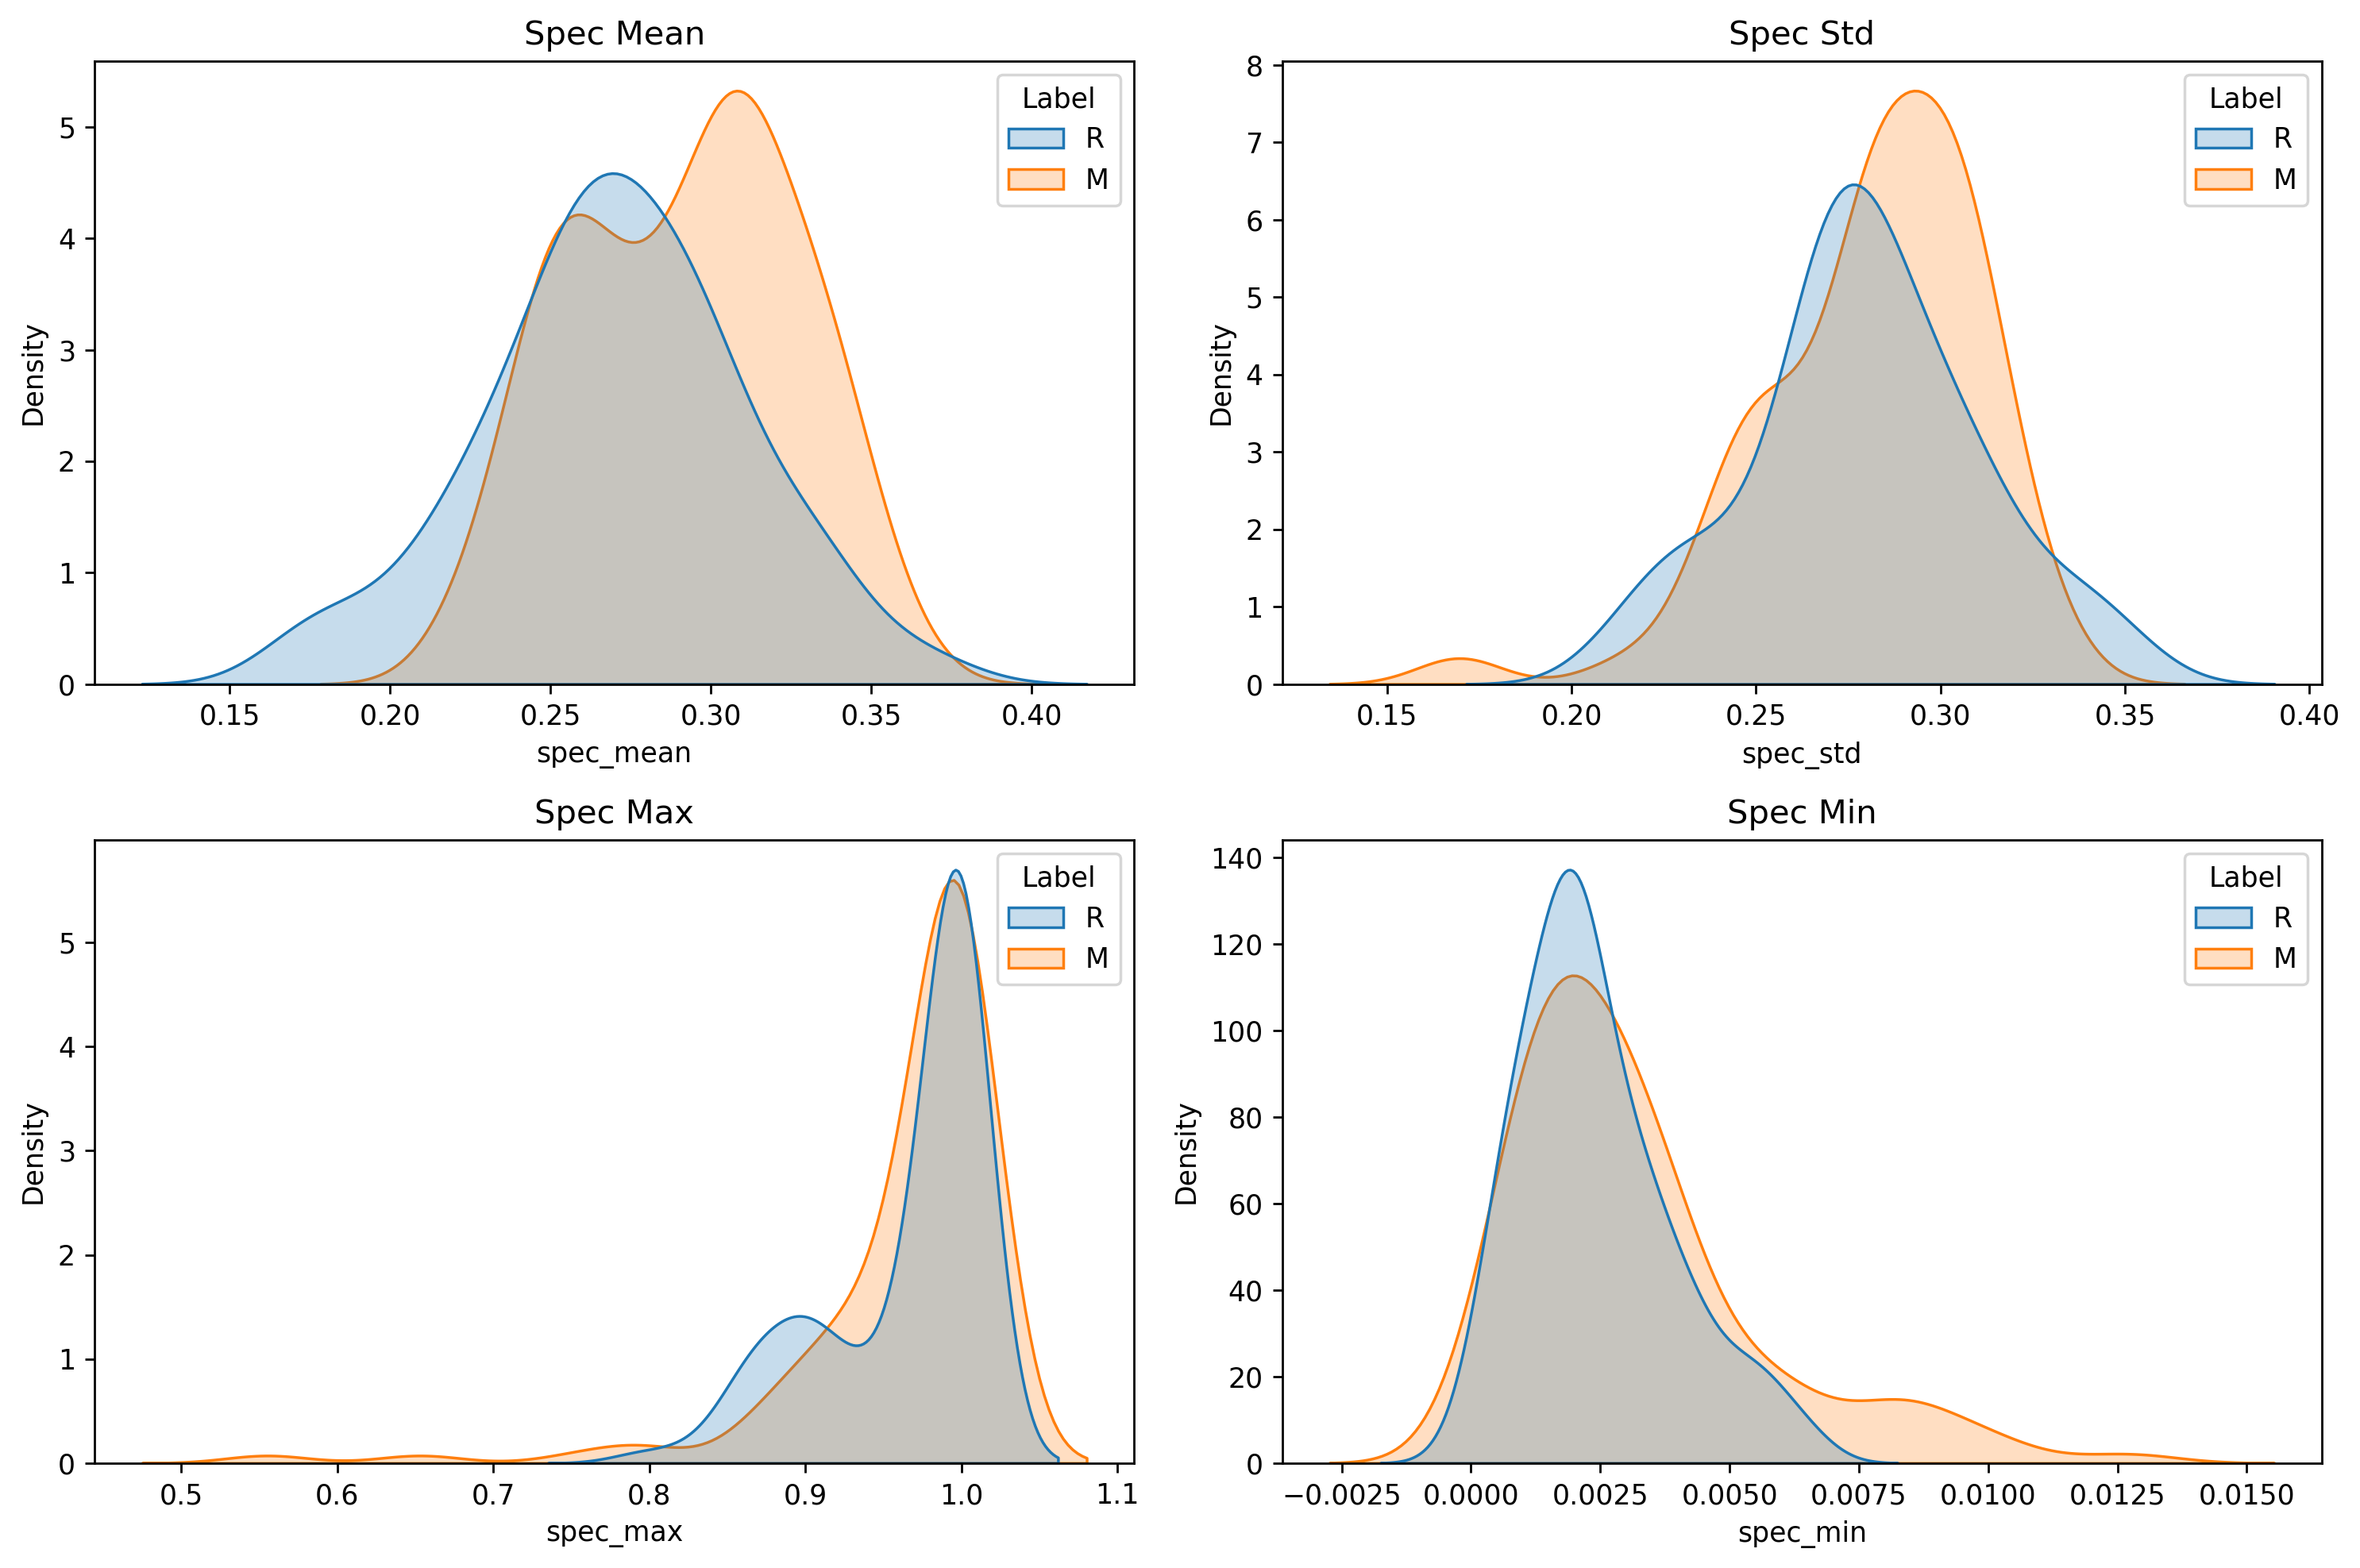

In [6]:
df['spec_mean'] = df.iloc[:,:60].mean(axis=1)
df['spec_std']  = df.iloc[:,:60].std(axis=1)
df['spec_max']  = df.iloc[:,:60].max(axis=1)
df['spec_min']  = df.iloc[:,:60].min(axis=1)

fig, axes = plt.subplots(2, 2, figsize=(12,8),dpi=250)
stats = ['spec_mean','spec_std','spec_max','spec_min']
for ax, stat in zip(axes.flatten(), stats):
    sns.kdeplot(data=df, x=stat, hue='Label', ax=ax, fill=True)
    ax.set_title(stat.replace('_',' ').title())
plt.tight_layout()
plt.savefig('visualizations/kde_plots.png')


**What are the top 5 correlated frequencies with the target\label?**


*Additional Note: We're looking at **absolute** correlation values.*

In [7]:
df['Target'] = df['Label'].map({'R':'Rock','M':'Mine'})
df.head()

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_57,Freq_58,Freq_59,Freq_60,Label,spec_mean,spec_std,spec_max,spec_min,Target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0180,0.0084,0.0090,0.0032,R,0.281562,0.259815,0.8537,0.0027,Rock
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0140,0.0049,0.0052,0.0044,R,0.276703,0.270859,1.0000,0.0044,Rock
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0316,0.0164,0.0095,0.0078,R,0.364200,0.289970,0.8929,0.0033,Rock
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0050,0.0044,0.0040,0.0117,R,0.266507,0.253826,0.9857,0.0036,Rock
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0072,0.0048,0.0107,0.0094,R,0.265382,0.239250,1.0000,0.0015,Rock


In [8]:
df['Target'] = df['Label'].map({'R':0,'M':1})
np.abs(df.select_dtypes('number').corr()['Target']).sort_values().tail(6)

Freq_45    0.339406
Freq_10    0.341142
Freq_49    0.351312
Freq_12    0.392245
Freq_11    0.432855
Target     1.000000
Name: Target, dtype: float64

### 4. Boxplots of Top‐Correlated Frequencies

**What it shows:**  
Boxplots for the five features most strongly correlated with the target (e.g., `Freq_45`, `Freq_10`, `Freq_49`, `Freq_12`, `Freq_11`), with separate boxes for Rocks vs. Mines.  

**Why it matters:**  
Boxplots highlight median shifts, interquartile ranges, and outliers, revealing which single frequencies are most discriminative.  

**Suggested caption:**  
“Rock vs. Mine distributions for each top‐correlated frequency feature.”  

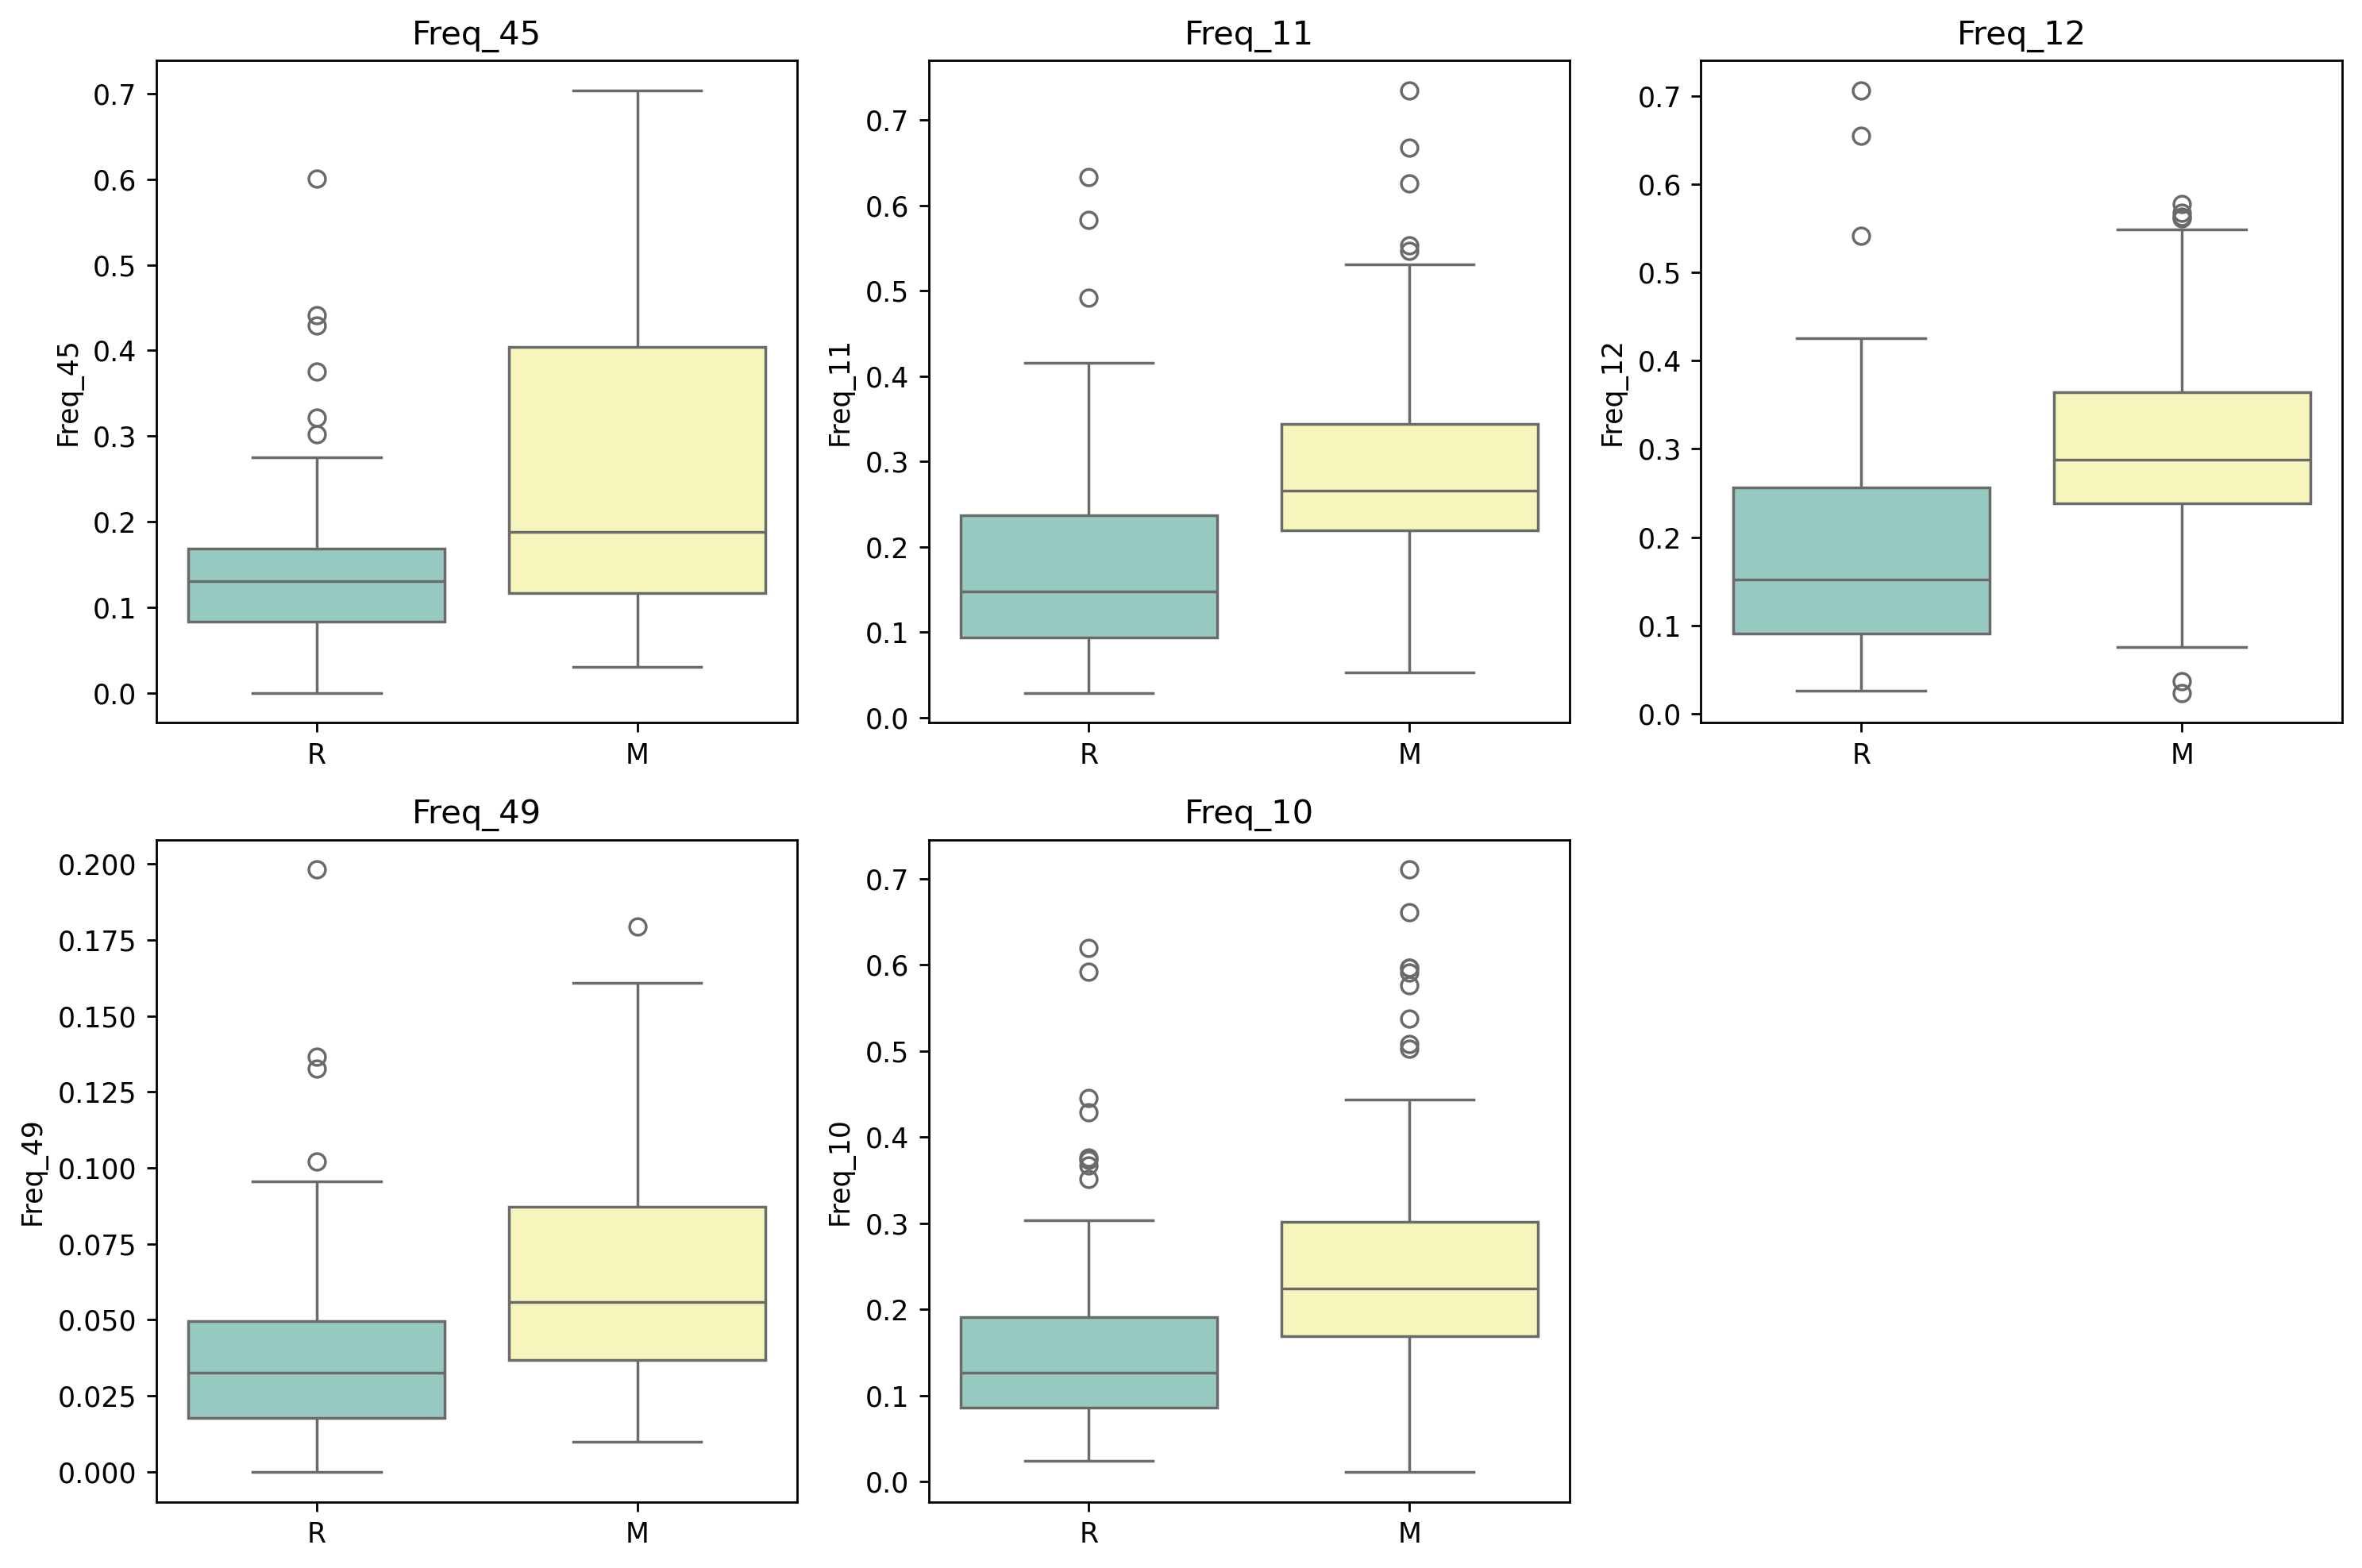

In [9]:
top5 = ['Freq_45','Freq_11','Freq_12','Freq_49','Freq_10']
plt.figure(figsize=(12,8),dpi=250)
for i,feat in enumerate(top5,1):
    plt.subplot(2,3,i)
    sns.boxplot(x='Label', y=feat, data=df,hue='Label', palette='Set3')
    plt.title(feat)
    plt.xlabel('')
plt.tight_layout()
plt.savefig('visualizations/top5_boxplots.png')


### 5. Pairwise Scatterplot of Top Features

**What it shows:**  
A seaborn `pairplot` of the top 5 correlated frequencies, with points colored by class and only the lower triangle shown.  

**Why it matters:**  
Visualizes two-dimensional separability and potential linear decision boundaries between Rock and Mine for each feature pair.  

**Notes for readers:**  
- Look for panels where the two colors form distinct clusters.  
- Assess which feature pairs might allow a simple 2D classifier.  

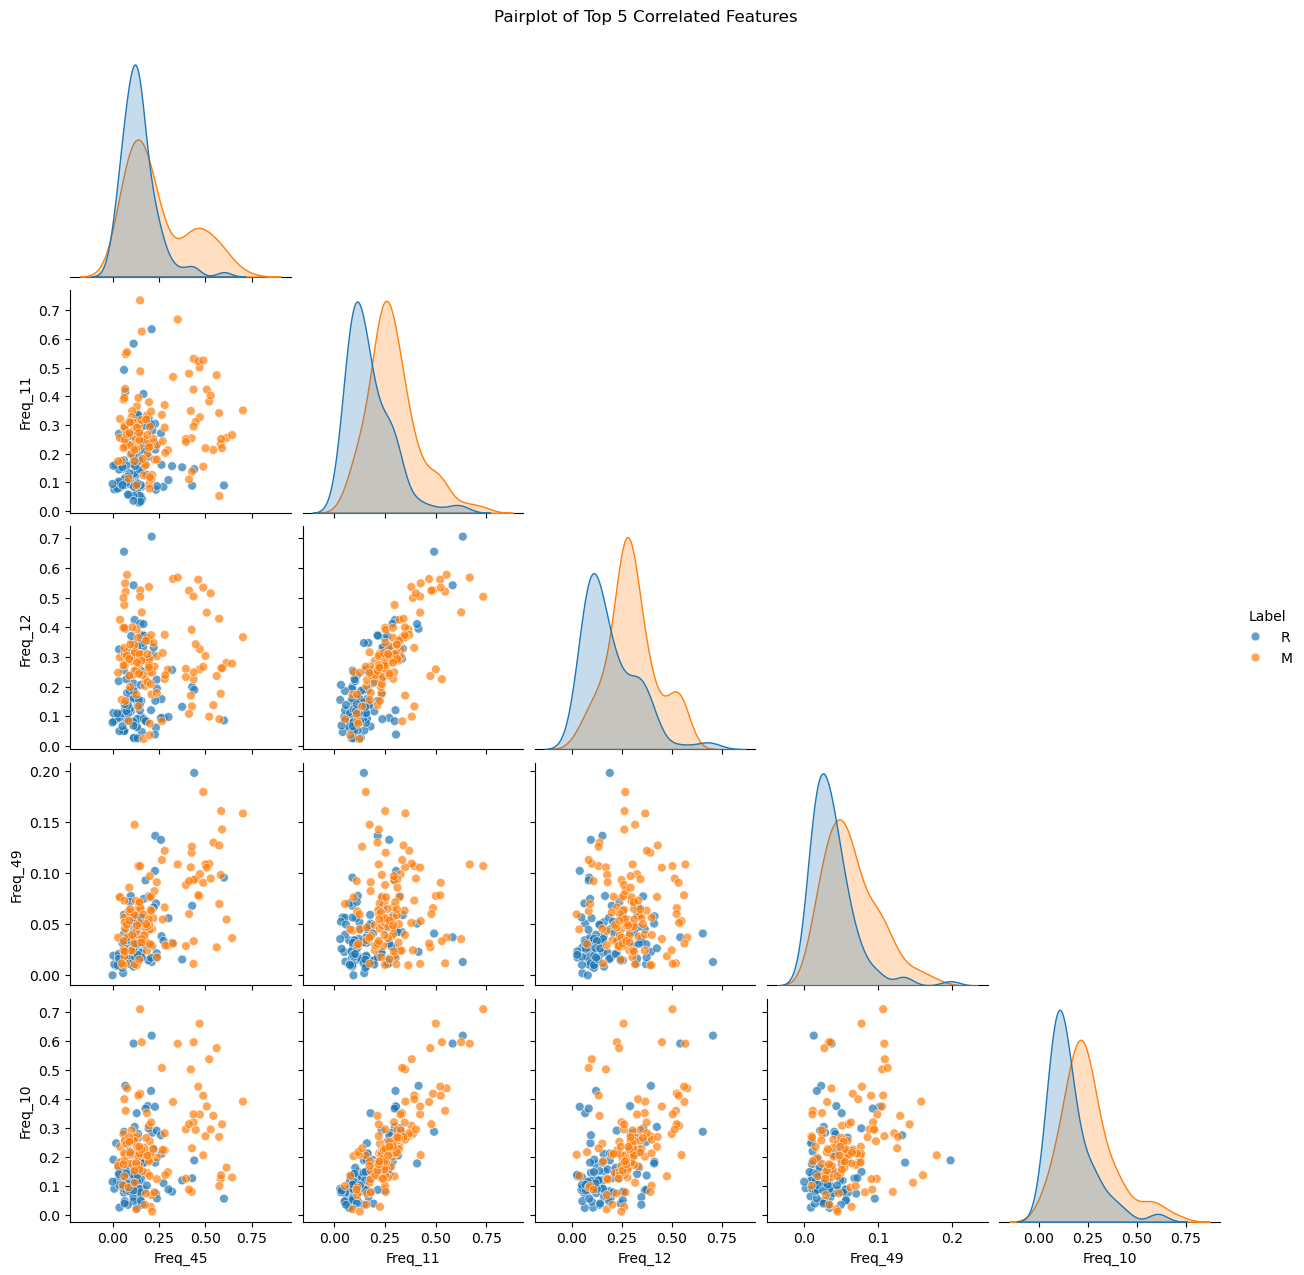

In [10]:
sns.pairplot(df[top5 + ['Label']], hue='Label', corner=True,
             plot_kws={'alpha':0.7,'s':40})
plt.suptitle('Pairplot of Top 5 Correlated Features', y=1.02)
plt.savefig('visualizations/top5_pairplot.png')


### 6 Correlation Heatmap of Frequency Responses

**What it shows:**  
A matrix of Pearson correlation coefficients between each pair of the 60 sonar frequency features.  Each cell (i, j) displays how strongly `Freq_i` and `Freq_j` move together across all rock and mine samples.

**Why it matters:**  
- Frequencies with very high correlation (near +1 or –1) carry redundant information—consider merging or dropping one.  
- Low‐correlation pairs (near 0) provide independent signals that can boost KNN’s discriminative power.  
- Identifying negatively correlated frequencies can reveal complementary patterns in the sonar echo.


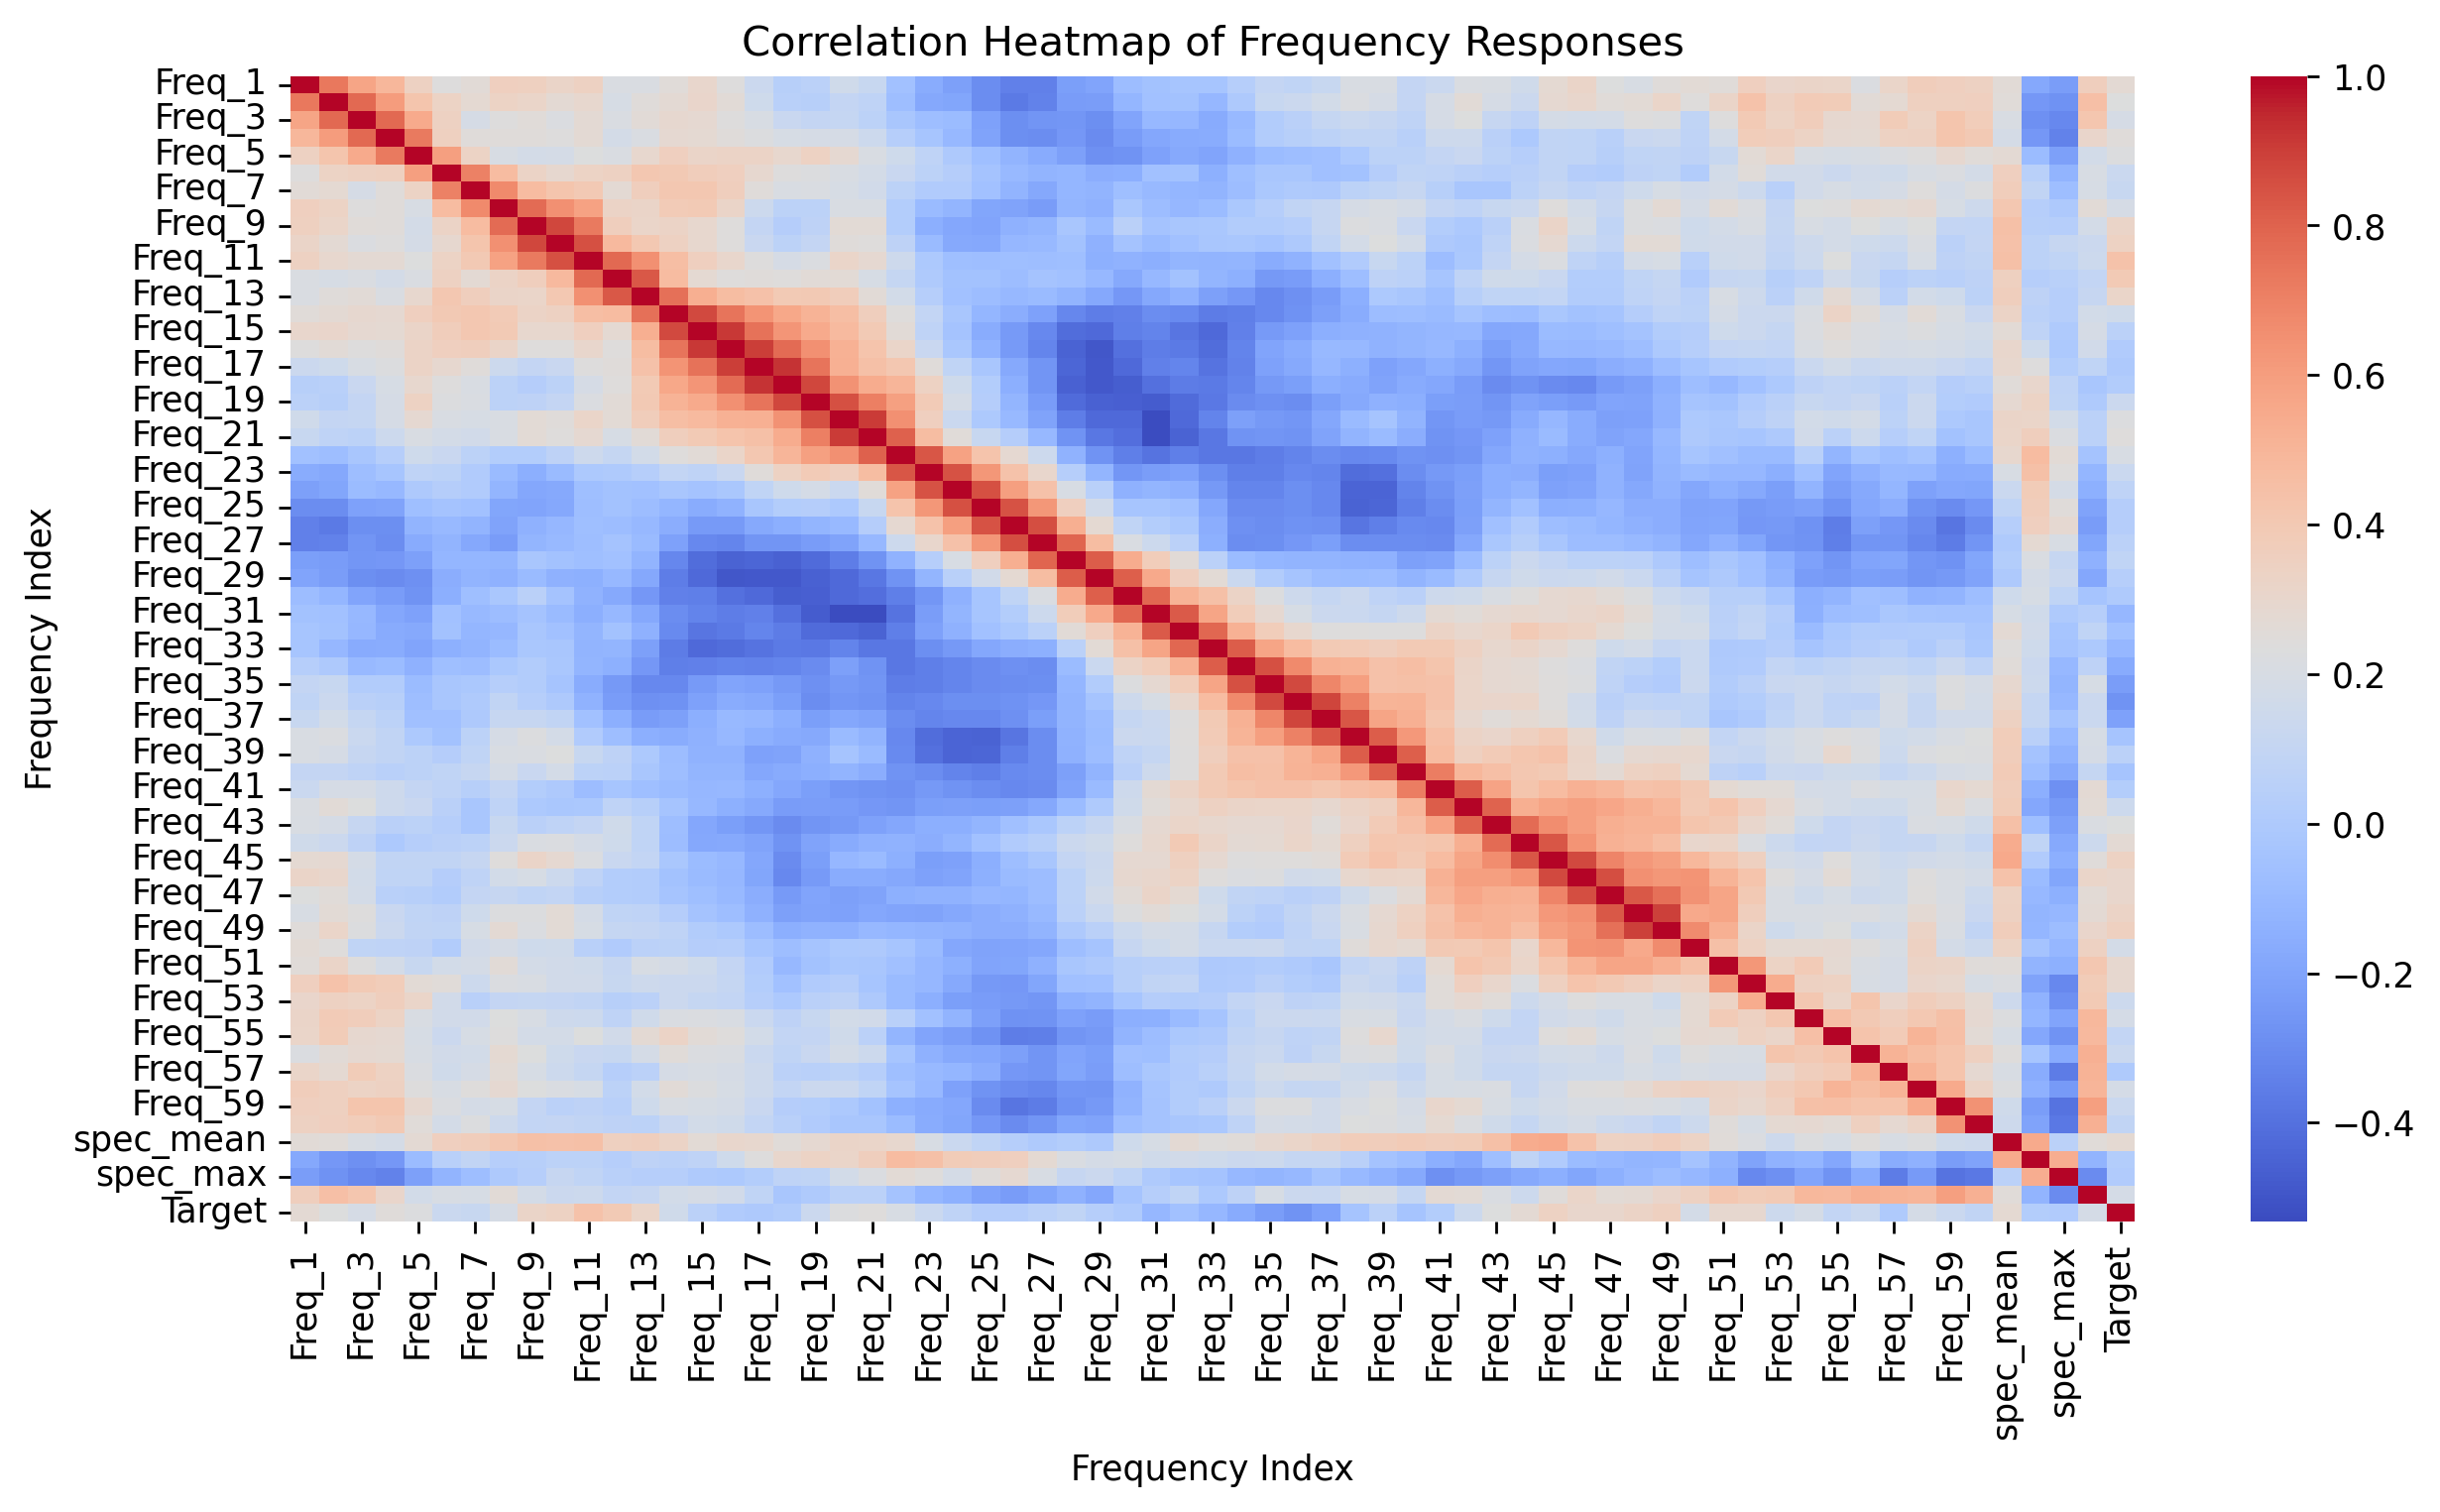

In [11]:
plt.figure(figsize=(12,6),dpi=250)
sns.heatmap(df.select_dtypes("number").corr(),cmap='coolwarm')
plt.title('Correlation Heatmap of Frequency Responses')
plt.xlabel('Frequency Index')
plt.ylabel('Frequency Index')
plt.savefig('visualizations/correlation_heatmap.png')


# 3 Feature Engineering Process

In this section we transform the raw 60-dimensional sonar amplitude vectors into a small set of interpretable signal-processing features. These engineered features capture key aspects of each echo's shape, allowing us to visualize class differences and feed more compact inputs into KNN.

#### 1. Spectral Centroid

The "center of mass" of the spectrum, representing the average frequency weighted by amplitude:

$$C = \frac{\sum_{i=1}^{60} f_i A_i}{\sum_{i=1}^{60} A_i}$$

#### 2. Spectral Bandwidth

Measures how spread out the spectrum is around the centroid:

$$B = \sqrt{\frac{\sum_{i=1}^{60} (f_i - C)^2 A_i}{\sum_{i=1}^{60} A_i}}$$

* **Intuition:** Signals with sharp peaks have low bandwidth; flatter echoes have higher bandwidth.

#### 3. Peak Frequency Index

Identifies the index of the strongest frequency component:

$$p = \arg\max_i A_i$$

* **Intuition:** The frequency bin with the highest amplitude. Different sound classes may peak in different bands.

#### 4. Spectral Roll-Off (90%)

The frequency bin below which 90% of the total spectral energy is contained:

$$r = \min \left\{ r \mid \frac{\sum_{i=1}^{r} A_i}{\sum_{i=1}^{60} A_i} \geq 0.9 \right\}$$

* **Intuition:** Sharp echoes concentrate energy at low frequencies (lower roll-off), while broader ones spread it out more (higher roll-off). By computing these four features for each ping, we reduce 60 raw amplitudes to four summary metrics that capture location, spread, peak, and energy distribution. These can be plotted to reveal class differences and used as compact inputs to classification.

In [12]:
# prepare frequency indices and amplitude array
freqs = np.arange(1, 61)  
amps  = df.iloc[:, :60].values       

In [13]:
# spectral centroid
centroid = (amps * freqs).sum(axis=1) / amps.sum(axis=1)
df['centroid'] = centroid

In [14]:
# spectral bandwidth (spread around centroid)
bandwidth = np.sqrt(
    ((freqs - centroid[:, None])**2 * amps).sum(axis=1)
    / amps.sum(axis=1)
)
df['bandwidth'] = bandwidth

In [15]:
#  peak‐frequency index
peak_idx = amps.argmax(axis=1) + 1
df['peak_freq'] = peak_idx

In [16]:
# 90% roll‐off: first index where cumulative energy ≥ 90% total
cumsum   = np.cumsum(amps, axis=1)
rolloff  = np.argmax(cumsum >= 0.9 * amps.sum(axis=1)[:, None], axis=1) + 1
df['rolloff_90'] = rolloff

### Plot A: Spectral Centroid Distribution by Class

**What it shows:**  
Overlaid KDE curves of the spectral centroid for Rock vs. Mine pings.

**Why it matters:**  
A shift in centroid distributions indicates that one class tends to concentrate its energy at consistently higher or lower frequency bands—a useful discriminative clue for KNN.


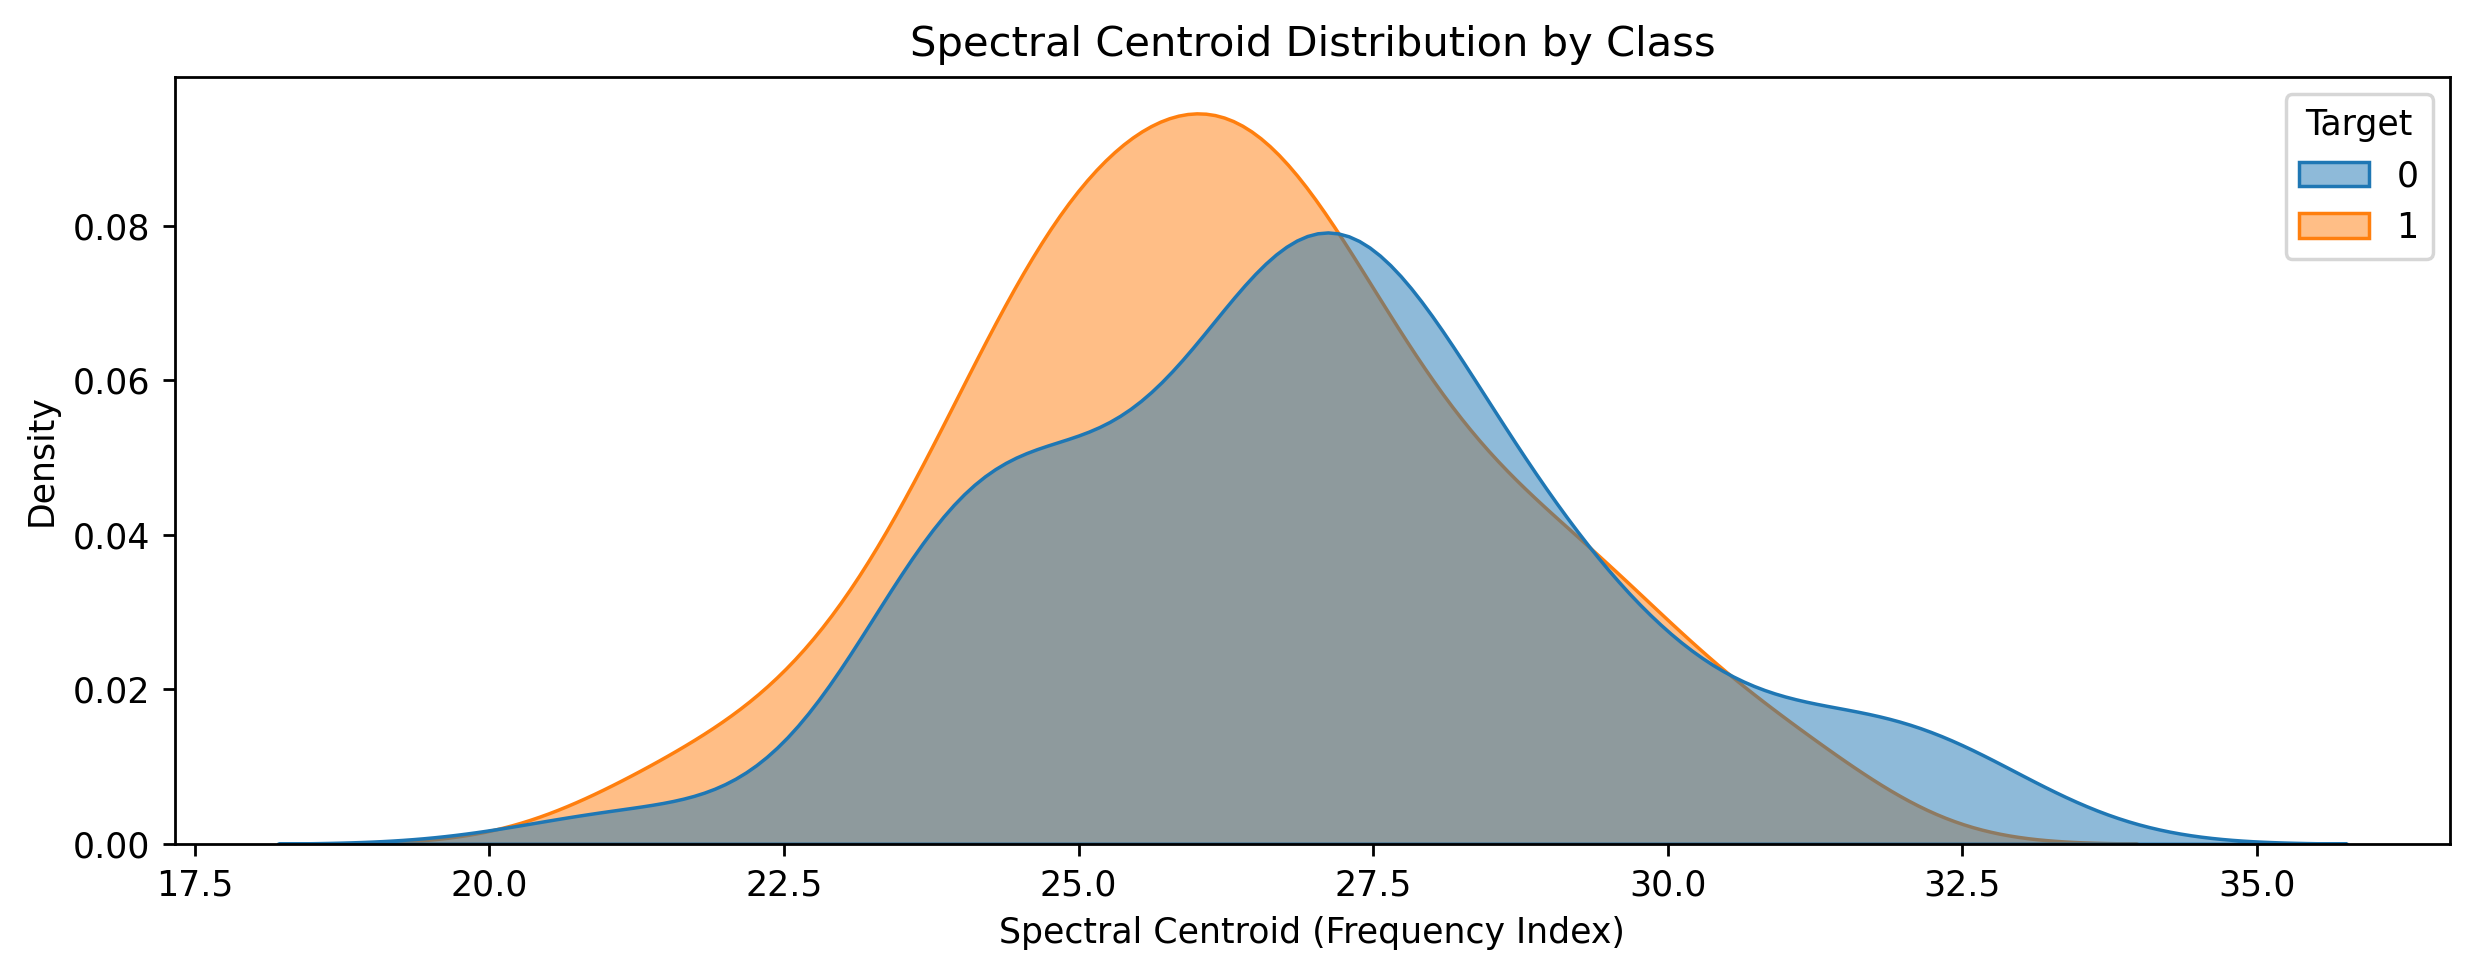

In [17]:
plt.figure(figsize=(10, 4),dpi=250)
sns.kdeplot(data=df, x='centroid', hue='Target', fill=True, alpha=0.5)
plt.title('Spectral Centroid Distribution by Class')
plt.xlabel('Spectral Centroid (Frequency Index)')
plt.ylabel('Density')
plt.savefig('visualizations/spectral_centroid_distribution.png')
plt.tight_layout()


### Plot B: Peak Frequency Index by Class

**What it shows:**  
A countplot of the frequency‐bin index where each echo attains its maximum amplitude, separated by class.

**Why it matters:**  
If Mines and Rocks peak at systematically different frequencies, the peak index becomes a simple yet powerful feature for classification.

---

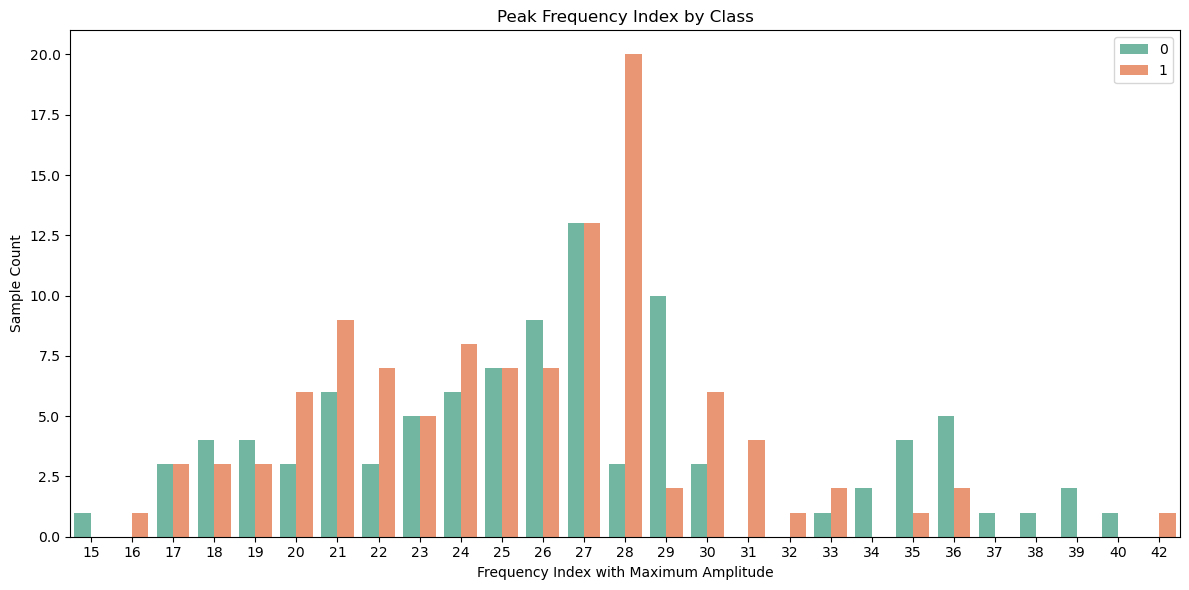

In [18]:
plt.figure(figsize=(12, 6))
sns.countplot(x='peak_freq', hue='Target', data=df, palette='Set2')
plt.title('Peak Frequency Index by Class')
plt.xlabel('Frequency Index with Maximum Amplitude')
plt.ylabel('Sample Count')
plt.legend(title='')
plt.tight_layout()
plt.savefig('visualizations/peak_frequency_index.png')


## Plot C: Spectral Roll-Off (90% Energy) by Class

**What it shows:**  
Overlaid KDE curves of the roll-off index at which 90% of each echo’s total energy is accumulated.

**Why it matters:**  
Different roll-off behavior (sharp vs. broad echoes) suggests distinct echo shapes for Rocks vs. Mines, giving KNN another reliable axis of separation.

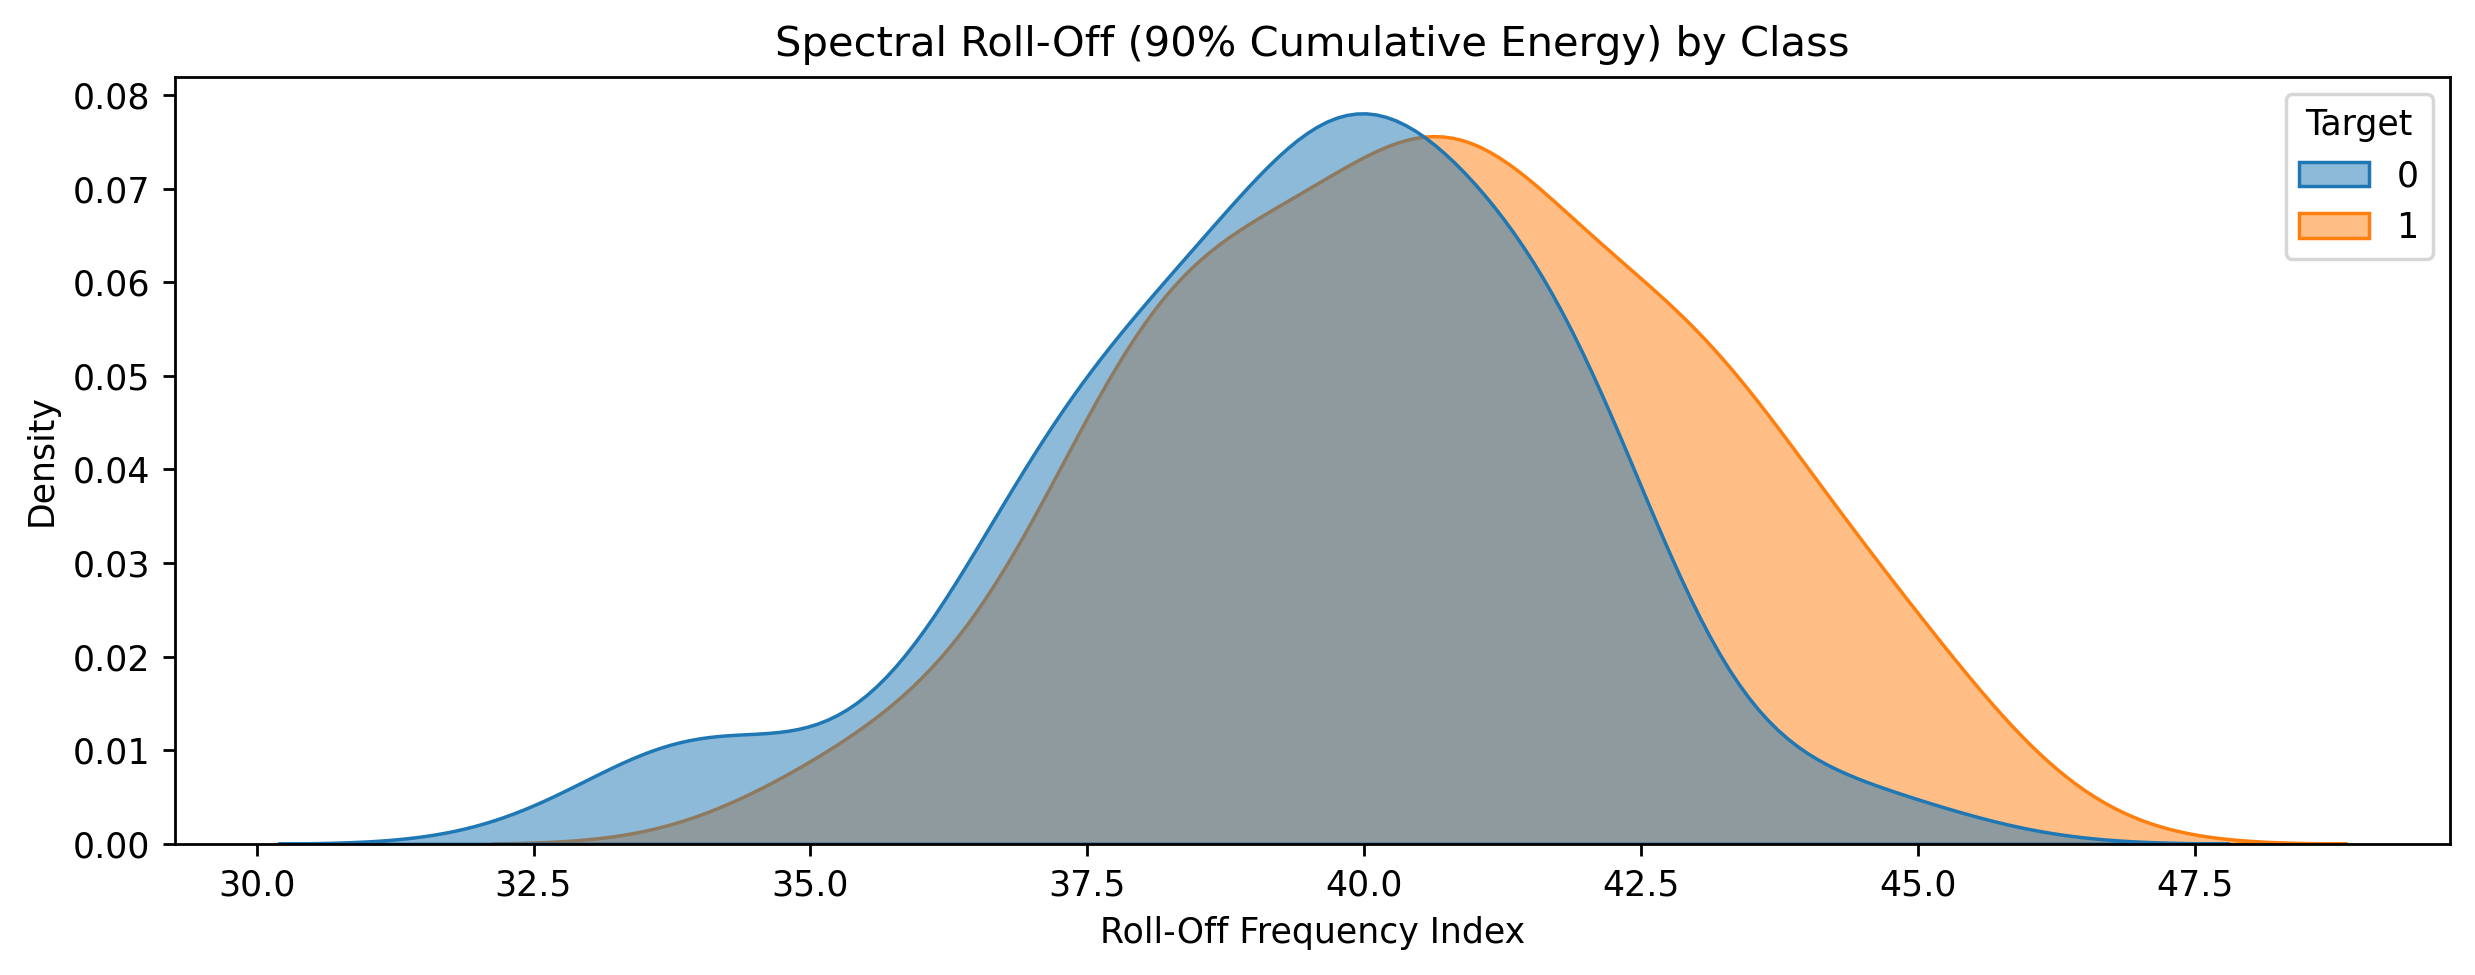

In [19]:
plt.figure(figsize=(10, 4),dpi=250)
sns.kdeplot(data=df, x='rolloff_90', hue='Target', fill=True, alpha=0.5)
plt.title('Spectral Roll-Off (90% Cumulative Energy) by Class')
plt.xlabel('Roll-Off Frequency Index')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('visualizations/spectral_roll-off.png')

### 7. PCA (2D) Projection of Sonar Signals

**What it shows:**  
A 2D scatter of the first two principal components (PC1 vs. PC2), with points colored by class.  

**Why it matters:**  
If Rock and Mine samples form separate clusters in PCA space, the data are amenable to low-dimensional modeling — good news for both KNN efficiency and interpretability.  

**Axes labels:**  
- PC1 (77.6% explained variance)  
- PC2 (15.1% explained variance)  

**Discussion prompts:**  
- Do you see overlapping regions or clear gaps?  

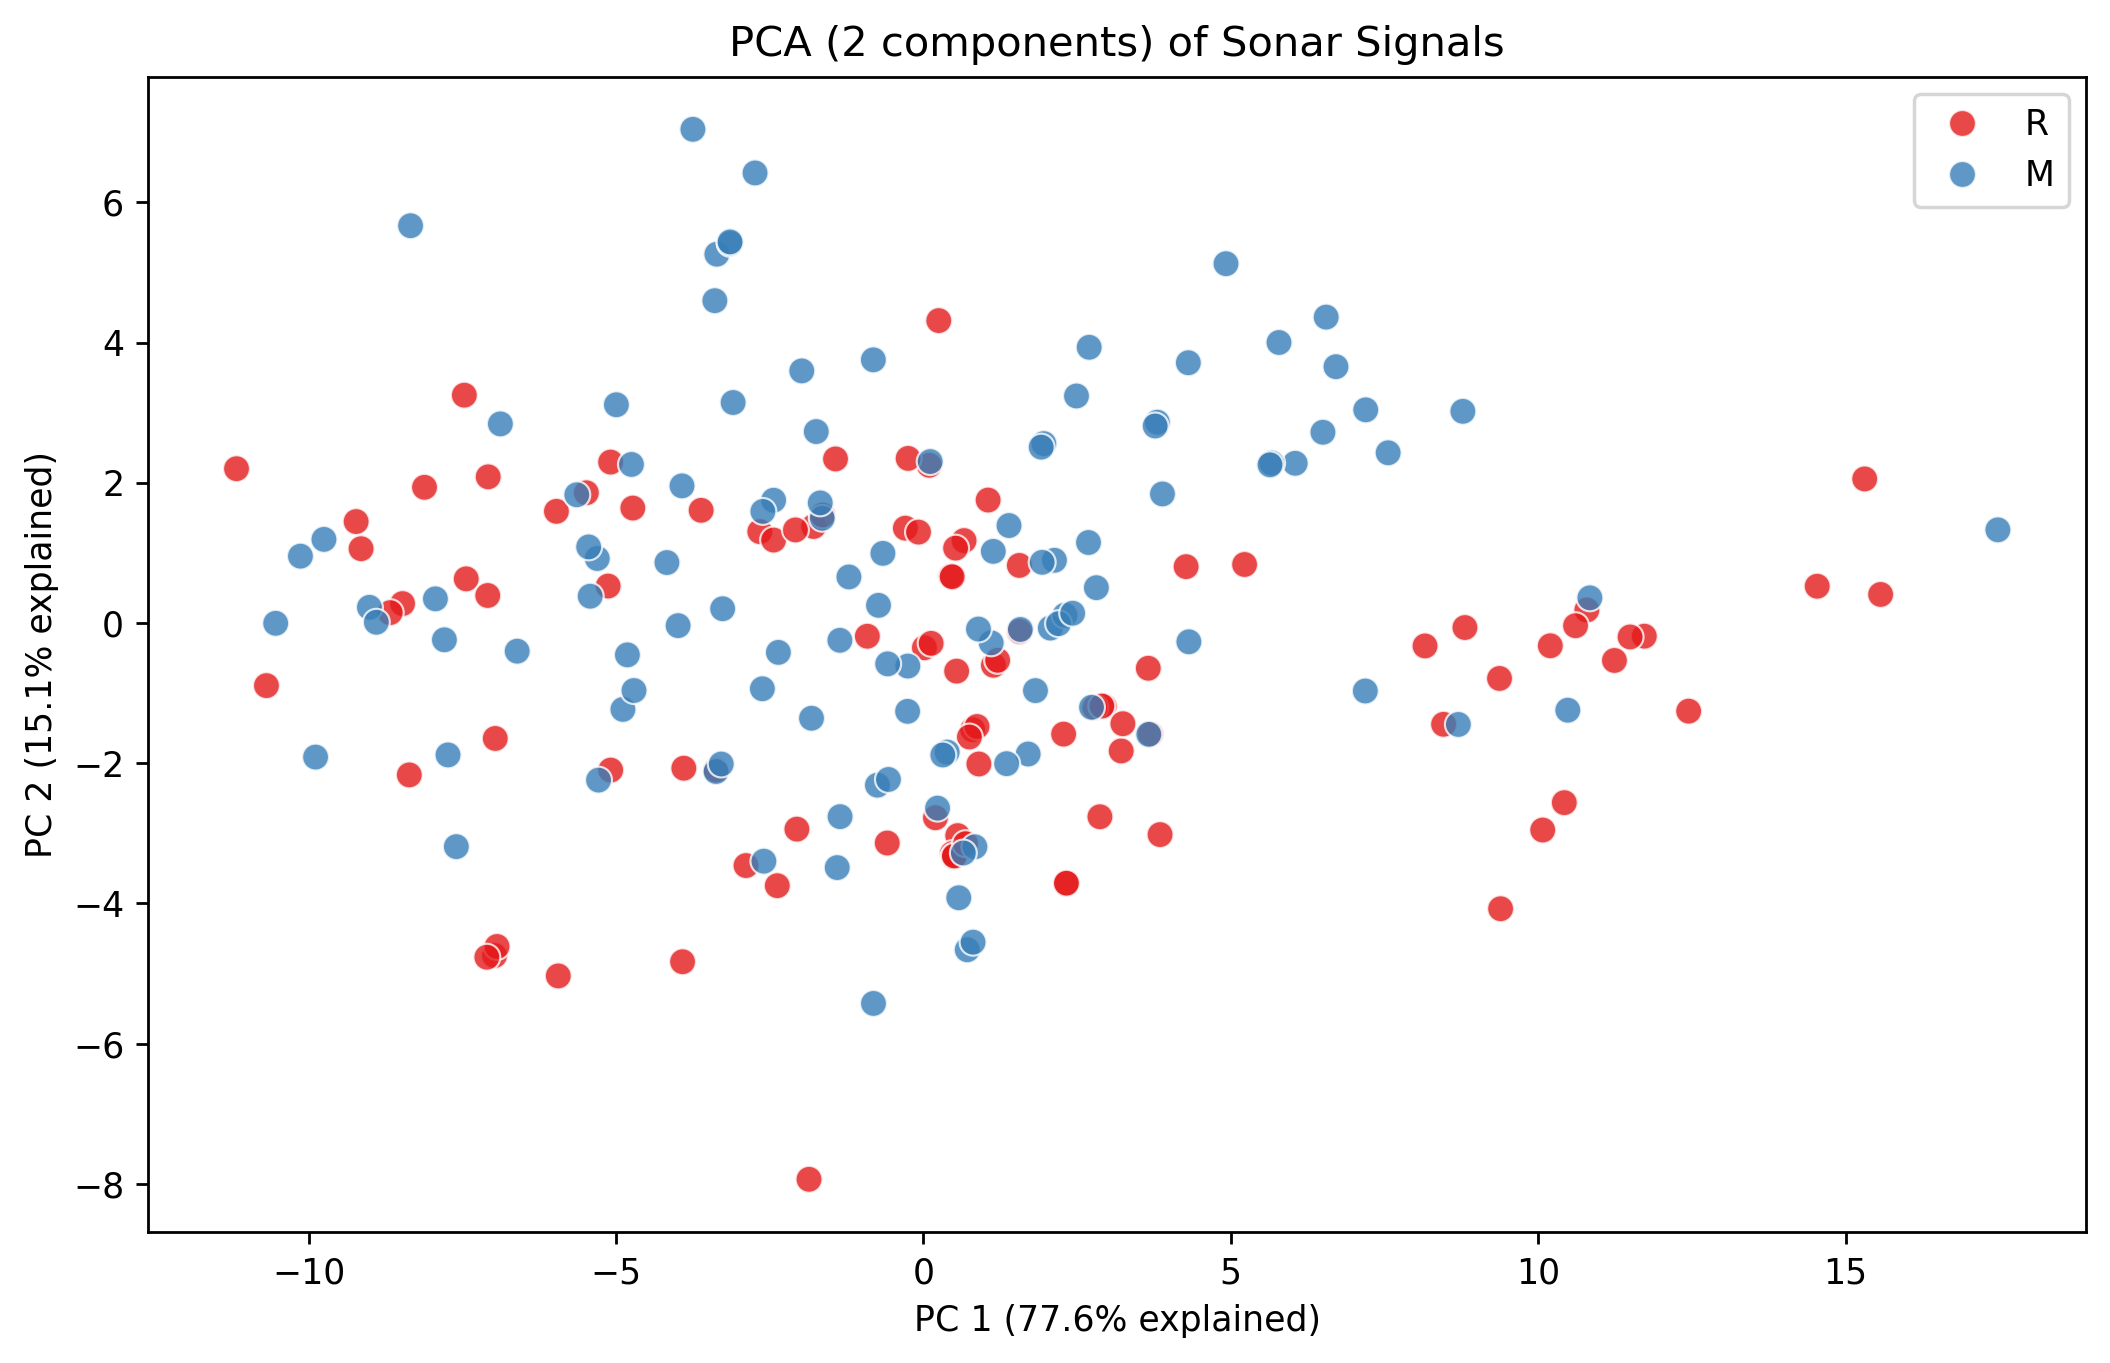

In [20]:
pca = PCA(n_components=2)
proj = pca.fit_transform(df.drop(['Target','Label'],axis=1))
plt.figure(figsize=(10,6),dpi=250)
sns.scatterplot(x=proj[:,0],y=proj[:,1],hue=df['Label'],palette='Set1',s=60,alpha=0.8)
plt.title('PCA (2 components) of Sonar Signals')
plt.xlabel('PC 1 (%.1f%% explained)' % (100*pca.explained_variance_ratio_[0]))
plt.ylabel('PC 2 (%.1f%% explained)' % (100*pca.explained_variance_ratio_[1]))
plt.legend()
plt.savefig('visualizations/pca_plot.png')


## Machine Learning 

### Train | Test Split

Our approach here will be one of using Cross Validation on 90% of the dataset, and then judging our results on a final test set of 10% to evaluate our model.

In [21]:
X = df.drop(['Target','Label'],axis=1)
y = df['Label']
X

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_59,Freq_60,spec_mean,spec_std,spec_max,spec_min,centroid,bandwidth,peak_freq,rolloff_90
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0090,0.0032,0.281562,0.259815,0.8537,0.0027,28.501506,10.367152,35,42
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0052,0.0044,0.276703,0.270859,1.0000,0.0044,21.372143,10.284901,17,37
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0095,0.0078,0.364200,0.289970,0.8929,0.0033,24.265697,11.151824,19,40
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0040,0.0117,0.266507,0.253826,0.9857,0.0036,31.544577,10.388579,39,44
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0107,0.0094,0.265382,0.239250,1.0000,0.0015,24.241106,10.329055,28,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,...,0.0193,0.0157,0.251983,0.284942,1.0000,0.0033,25.776401,9.725091,28,39
204,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,...,0.0062,0.0067,0.252988,0.308975,1.0000,0.0032,25.971613,8.849852,28,36
205,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,...,0.0077,0.0031,0.241685,0.302327,1.0000,0.0029,26.221521,8.938262,28,36
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,...,0.0036,0.0048,0.239705,0.284369,1.0000,0.0034,25.640440,9.214871,26,38


In [22]:
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Building a Preprocessing + Model Pipeline

Rather than scaling features and training KNN in separate steps—which risks data leakage—we bundle them into a single `Pipeline`.  This ensures that during cross‐validation, each fold applies `StandardScaler` **only** on its training data before fitting the KNN model.

**Why use a Pipeline?**  
- **No data leakage:** Scaling parameters (mean, std) are computed on the training fold, never on the held‐out fold.  
- **Clean code:** One object manages all steps, making grid‐search and deployment straightforward.  
- **Consistent API:** You can call `.fit`, `.predict`, and `.score` just once on the pipeline.

> **Next up:** We’ll perform a grid‐search over `knn__n_neighbors` using this pipeline and 5-fold cross‐validation on 90% of the data.  

In [23]:
scaler = StandardScaler()

In [24]:
knn = KNeighborsClassifier()

In [25]:
operations = [('scaler',scaler),('knn',knn)]

In [26]:
pipe = Pipeline(operations)

### Hyperparameter Tuning via Grid Search

We’ll use `GridSearchCV` on our `pipeline` to find the optimal number of neighbors \(k\). By scoring on 10‐fold cross‐validation within the 90% “CV” partition, we identify which `knn__n_neighbors` gives the highest average accuracy.

**Key points:**  
- We wrap both scaling and classification in the same pipeline to avoid data leakage.  
- The best `k` is the one that maximizes average accuracy across the 10 folds.  
- We can now refit the pipeline with this `k` on all 90% CV data and evaluate on the held‐out 10% test set.  

In [27]:
k_values = list(range(1,30))

In [28]:
param_grid = {
    'knn__n_neighbors': k_values,
}

In [29]:
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=10,scoring='accuracy')

In [30]:
full_cv_classifier.fit(X_cv,y_cv)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29]},
             scoring='accuracy')

In [31]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=1))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=1),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 1,
 'knn__p': 2,
 'knn__weights': 'uniform'}

### Visualizing CV Performance Across \(k\) Values

**Objective**  
Plot the mean cross‐validated test accuracy for each candidate number of neighbors (\(k\)) so we can visually inspect how performance evolves as \(k\) changes.

**Why This Matters**  
- Reveals the bias–variance tradeoff:  
  - Small \(k\) → low bias, high variance (overfitting)  
  - Large \(k\) → high bias, low variance (underfitting)  
- Helps pinpoint the “sweet spot” where accuracy peaks.  
- Makes it easy to justify the chosen hyperparameter.


In [32]:
full_cv_classifier.cv_results_['mean_test_score']

array([0.81842105, 0.81812865, 0.78625731, 0.77017544, 0.77602339,
       0.75964912, 0.79152047, 0.73274854, 0.73274854, 0.72192982,
       0.72192982, 0.73304094, 0.72719298, 0.70087719, 0.71695906,
       0.7002924 , 0.70526316, 0.68918129, 0.69444444, 0.71081871,
       0.69444444, 0.69473684, 0.70584795, 0.70555556, 0.71666667,
       0.71666667, 0.71637427, 0.71637427, 0.70584795])

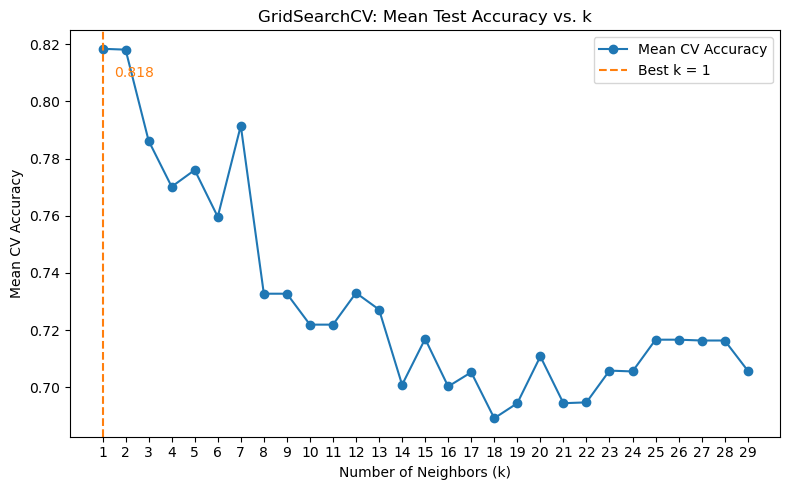

In [33]:
# 1. Retrieve results
k_values = list(range(1, 30))
mean_scores = full_cv_classifier.cv_results_['mean_test_score']
best_k = full_cv_classifier.best_params_['knn__n_neighbors']
best_score = full_cv_classifier.best_score_

# 2. Make the plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, mean_scores, 'o-', color='C0', label='Mean CV Accuracy')

# 3. Highlight best k
plt.axvline(best_k, color='C1', linestyle='--', label=f'Best k = {best_k}')
plt.text(best_k+0.5, best_score-0.01, f'{best_score:.3f}', color='C1')

# 4. Finalize
plt.title('GridSearchCV: Mean Test Accuracy vs. k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean CV Accuracy')
plt.xticks(k_values)
plt.legend()
plt.tight_layout()
plt.savefig('visualizations/grid_search_accuracy.png')
plt.show()

### Final Model Evaluation on the Held-Out Test Set

Now that we’ve tuned our pipeline and selected the best \(k\), it’s time to measure how well the final model generalizes to completely unseen data. We will:

 **Confusion Matrix (Heatmap)**  
   Visualize True Positives, False Positives, False Negatives, and True Negatives in a heatmap. This helps us understand the types of errors our KNN makes.

 **Classification Report**  
   Print precision, recall, f1-score, and support for each class.  
   - **Precision:** Of all pings predicted as “Mine,” how many truly were mines?  
   - **Recall:** Of all real mines, how many did we correctly detect?  
   - **F1-Score:** The harmonic mean of precision and recall.

 **Overall Accuracy**  
   Report the fraction of pings correctly classified on the test set.

In [34]:
pred = full_cv_classifier.predict(X_test)

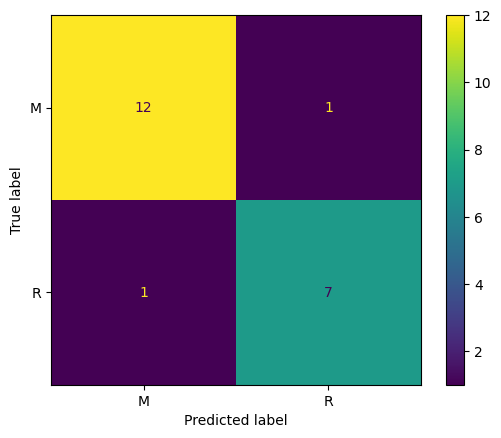

In [35]:
ConfusionMatrixDisplay.from_predictions(y_test,pred)
plt.savefig('visualizations/confusion_matrix.png')

In [36]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           M       0.92      0.92      0.92        13
           R       0.88      0.88      0.88         8

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21



## Conclusion & Final Model Performance

After tuning our K-Nearest Neighbors classifier (with \(k=1\)) on 90% of the data and evaluating on the held-out 10%, we achieved the following results:

| Class  | Precision | Recall | F1-Score | Support |
|:------:|:---------:|:------:|:--------:|:-------:|
| Mine (M) |   0.92    |  0.92  |   0.92   |   13    |
| Rock (R) |   0.88    |  0.88  |   0.88   |    8    |
| **Overall** | **0.90** | **0.90** | **0.90** |   21    |

Key takeaways:

- **Accuracy (90%)**  
  90% of all test samples were correctly classified, indicating strong generalization.

- **Balanced Performance**  
  Both classes exhibit high precision and recall, with only a slight dip for rocks (R).

- **Error Analysis**  
  - False positives (misclassifying rock as mine) and false negatives (missing a mine) occur at similar low rates.  
  - In a safety-critical setting, one might choose to tune for slightly higher recall on mines at the cost of some precision.

- **Next Steps**  
  - Explore weighting neighbors by distance or alternate metrics (e.g. Mahalanobis).  
  - Compare against other classifiers (e.g. SVM, Random Forest) for robustness.  
  - Investigate misclassified examples to identify potential feature gaps or noise.

Overall, the simple KNN pipeline—coupled with basic feature engineering and rigorous CV—yields a reliable 90% accuracy on unseen sonar data.

## Model Persistence

Once we’re satisfied with our KNN pipeline, we first **refit** it on the **entire** dataset (all features `X` and labels `y`) so that it benefits from every sample before we serialize it:


In [37]:
full_cv_classifier.fit(X,y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29]},
             scoring='accuracy')

In [43]:
# Define file path
MODEL_PATH = 'models/knn_sonar_model.joblib'
CSV_PATH = 'DATA/final_engineered_sonar.csv'

In [44]:
#Save the trained pipeline
joblib.dump(full_cv_classifier.best_estimator_, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")
df.to_csv('DATA/final_engineered_sonar')
print(f"CSV saved to {CSV_PATH}")

Model saved to models/knn_sonar_model.joblib
CSV saved to DATA/final_engineered_sonar.csv


### Predicting on a “Random” Sonar Ping

Below we generate a single synthetic sonar example by sampling each of the 60 frequency amplitudes uniformly between the minimum and maximum values observed in the original dataset. This mimics “new” data that was never part of our train/test split.

**Explanation:**
1. We extract the min/max of each of the 60 features from our original DataFrame `df`.  
2. We draw a uniform random value for each feature within its observed range.  
3. We package these 60 values into a Pandas DataFrame with the same column names.  
4. Finally, we call `loaded_model.predict` (and optionally `predict_proba`) to see how our saved KNN pipeline classifies this entirely new example.  

In [40]:
loaded_model = joblib.load(MODEL_PATH)

In [41]:
idx = np.random.randint(len(X_test))
sample_X = X_test.iloc[idx:idx+1]
true_y   = y_test.iloc[idx]
pred_y   = loaded_model.predict(sample_X)[0]

In [42]:
print(f"Sample index: {idx}")
print(f"True label : {true_y}")
print(f"Predicted  : {pred_y}")

Sample index: 0
True label : M
Predicted  : M
